<a href="https://colab.research.google.com/github/sudiptiwari/Handwritten-Devanagari-Conjunct-Consonant-Characters/blob/main/code_to_crop_and_resize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Cropping, GrayScale and Binary Output Images**

**Target Output Size is 64*64**

Import Libraries and Set Target Size

In [ ]:
import cv2
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import random

Define a Function to Crop (Grayscale Output)

In [ ]:
def crop_character_with_inner_margin(image_path, margin=5):
    """
    Loads a grayscale image from the given path, finds the bounding box of the
    non-white pixels (i.e. the foreground character), and then crops the image
    by removing 'margin' pixels from each side of that bounding box (if possible).

    This ensures that the character is centrally cropped with a 5-pixel gap on each side,
    without resizing the image to a fixed size.

    Parameters:
      image_path: Path to the image file.
      margin: Number of pixels to remove from each side of the bounding box.

    Returns:
      Cropped grayscale image as a NumPy array, or None if no character is found.
    """
    # Load the image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Unable to read image: {image_path}")
        return None

    # Apply thresholding to highlight the character using Otsu's method
    _, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Get coordinates of non-white (foreground) pixels
    coords = np.column_stack(np.where(binary > 0))
    if coords.shape[0] == 0:
        return None  # No character found

    # Get the bounding box for the character
    x_min, y_min = coords.min(axis=0)
    x_max, y_max = coords.max(axis=0)

    # Expand the bounding box by 'margin' pixels on all sides, while clamping to image dimensions
    x_min_new = max(0, x_min - margin)
    y_min_new = max(0, y_min - margin)
    x_max_new = min(img.shape[0], x_max + margin)
    y_max_new = min(img.shape[1], y_max + margin)

    # Crop the original image based on the new bounding box
    cropped = img[x_min_new:x_max_new, y_min_new:y_max_new]
    return cropped

Define a Function to resize Binarized Image to 64*64

In [ ]:
def resize_image_lanczos(image_path, output_size=64):
    """
    Resizes the input image to (output_size x output_size) using Lanczos interpolation.

    Parameters:
      image_path: Path to the image file.
      output_size: The desired output size (square); default is 64.

    Returns:
      A PIL Image object in grayscale ('L' mode) resized to (output_size x output_size).
    """
    # Open the image and ensure it is in grayscale
    image = Image.open(image_path).convert("L")

    # Resize using Lanczos interpolation
    resized_image = image.resize((output_size, output_size), Image.LANCZOS)

    return resized_image

Function to Resize Binarized Image using LANCZOS Interpolation to 64*64

In [ ]:
def resize_binary_image_lanczos(image_path, output_size=64):
    """
    Reads a binarized image from image_path, ensures it is in grayscale,
    and then resizes it to (output_size x output_size) using Lanczos interpolation.
    After resizing, the image is re-binarized (via Otsu's thresholding) to ensure a
    clean binary output.

    Parameters:
      image_path: Path to the input binary image.
      output_size: The desired output image size (square).

    Returns:
      A PIL Image object in binary mode ('1').
    """
    # Open the image with PIL and convert to grayscale
    image = Image.open(image_path).convert("L")

    # Convert to numpy array for thresholding
    gray_np = np.array(image)
    # Binarize using Otsu's thresholding (here we do THRESH_BINARY, since we assume image is already binary)
    _, binary_np = cv2.threshold(gray_np, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    binary_image = Image.fromarray(binary_np)

    # Resize using Lanczos interpolation
    resized_image = binary_image.resize((output_size, output_size), Image.LANCZOS)

    # Re-binarize the resized image to ensure it remains binary
    resized_gray_np = np.array(resized_image)
    _, resized_binary_np = cv2.threshold(resized_gray_np, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # final_image = Image.fromarray(resized_binary_np).convert("1")  # convert to mode '1' for pure binary
    final_image = Image.fromarray(resized_binary_np).convert("1", dither=Image.NONE)

    return final_image

Loop through all files in the Original folder and convert to grayscale
## Run this Code to Save Centrally Cropped Images in non-Square Dimension
### Output: 1

In [ ]:
cc_name = "CC_26" # Replace with directory-name consisting of number of images of same class

# Set the input folder containing your images
input_folder = "Source_Directory/"+cc_name  # update with your folder path

# Create output folders for grayscale and binarized images
output_folder_gray = "Output_Directory/1-Gray-Centrally-Cropped-Images/"+cc_name
output_folder_gray_64 = "Output_Directory/2.1-Gray-64X64-Images/"+cc_name
output_folder_binary = "Output_Directory/2.2-Binary-Centrally-Cropped-Images/"+cc_name
resized_output_folder = "Output_Directory/3-Resized-Binary-Images/"+cc_name
os.makedirs(output_folder_gray, exist_ok=True)
os.makedirs(output_folder_binary, exist_ok=True)
os.makedirs(resized_output_folder, exist_ok=True)
os.makedirs(output_folder_gray_64, exist_ok=True)

In [ ]:
# Process each image in the input folder and save the cropped output
for filename in tqdm(os.listdir(input_folder)):
    if filename.lower().endswith((".png", ".jpg", ".jpeg")):
        input_path = os.path.join(input_folder, filename)
        cropped_img = crop_character_with_inner_margin(input_path, margin=5)
        if cropped_img is not None:
            output_path = os.path.join(output_folder_gray, filename)
            cv2.imwrite(output_path, cropped_img)

### **!!!!!!!!!! Check output_folder_gray and crop images if they are not centrally cropped !!!!!!!!!!**

### **!!!!!!!!!! Check output_folder_gray and crop images if they are not centrally cropped !!!!!!!!!!**

Loop through all files in the grayscale folder and convert it to 64*64
## Run this code to convert Grayscale Images to 64*64 Grayscale images and Save them
### Output: 2.1

In [ ]:
# Loop over all images in the grayscale folder, resize them, and save the output
for filename in tqdm(os.listdir(output_folder_gray)):
    if filename.lower().endswith((".png", ".jpg", ".jpeg")):
        input_path = os.path.join(output_folder_gray, filename)
        resized_img = resize_image_lanczos(input_path, output_size=64)

        # Save the resized image
        output_path = os.path.join(output_folder_gray_64, filename)
        resized_img.save(output_path)

100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [00:04<00:00, 70.78it/s]


Loop through all files in the grayscale folder and convert to binary
## Run this code to loop through each Centrally Cropped Image and Convert it to Binary Image in non-Square Size
### Output: 2.2

In [ ]:
# Loop through all files in the grayscale folder and convert to binary
for filename in tqdm(os.listdir(output_folder_gray)):
    if filename.lower().endswith((".png", ".jpg", ".jpeg")):
        gray_path = os.path.join(output_folder_gray, filename)

        # Load the grayscale image
        gray_img = cv2.imread(gray_path, cv2.IMREAD_GRAYSCALE)
        if gray_img is None:
            print(f"Unable to read image: {gray_path}")
            continue

        # Apply Otsu's thresholding with inversion
        # (This converts the image so that the character becomes white and the background black)
        _, binary_img = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

        # Optional: If you want to resize the image to a fixed target size (if not already done)
        # binary_img = cv2.resize(binary_img, (target_size, target_size), interpolation=cv2.INTER_AREA)

        # Save the binary image in the output folder
        binary_path = os.path.join(output_folder_binary, filename)
        cv2.imwrite(binary_path, binary_img)

100%|███████████████████████████████████████████████████████████████████████████████| 299/299 [00:00<00:00, 355.69it/s]


Process all Binarized Images and resize them to fixed size using LANCZOS Interpolation
## Run this code to resize all Binarized images to 64*64 using LANCZOS interpolation
### Output: 3

In [ ]:
# Loop over all image files in the binary input folder
# Change this value to change the final size of Output Binarized Image after LANCZOS interpolation
output_image_size = 64

for filename in tqdm(os.listdir(output_folder_binary)):
    if filename.lower().endswith((".png", ".jpg", ".jpeg")):
        image_path = os.path.join(output_folder_binary, filename)
        final_img = resize_binary_image_lanczos(image_path, output_size=output_image_size)
        if final_img is not None:
            final_img.save(os.path.join(resized_output_folder, filename))

100%|███████████████████████████████████████████████████████████████████████████████| 299/299 [00:02<00:00, 108.89it/s]


Display Some Processed Images Side by Side

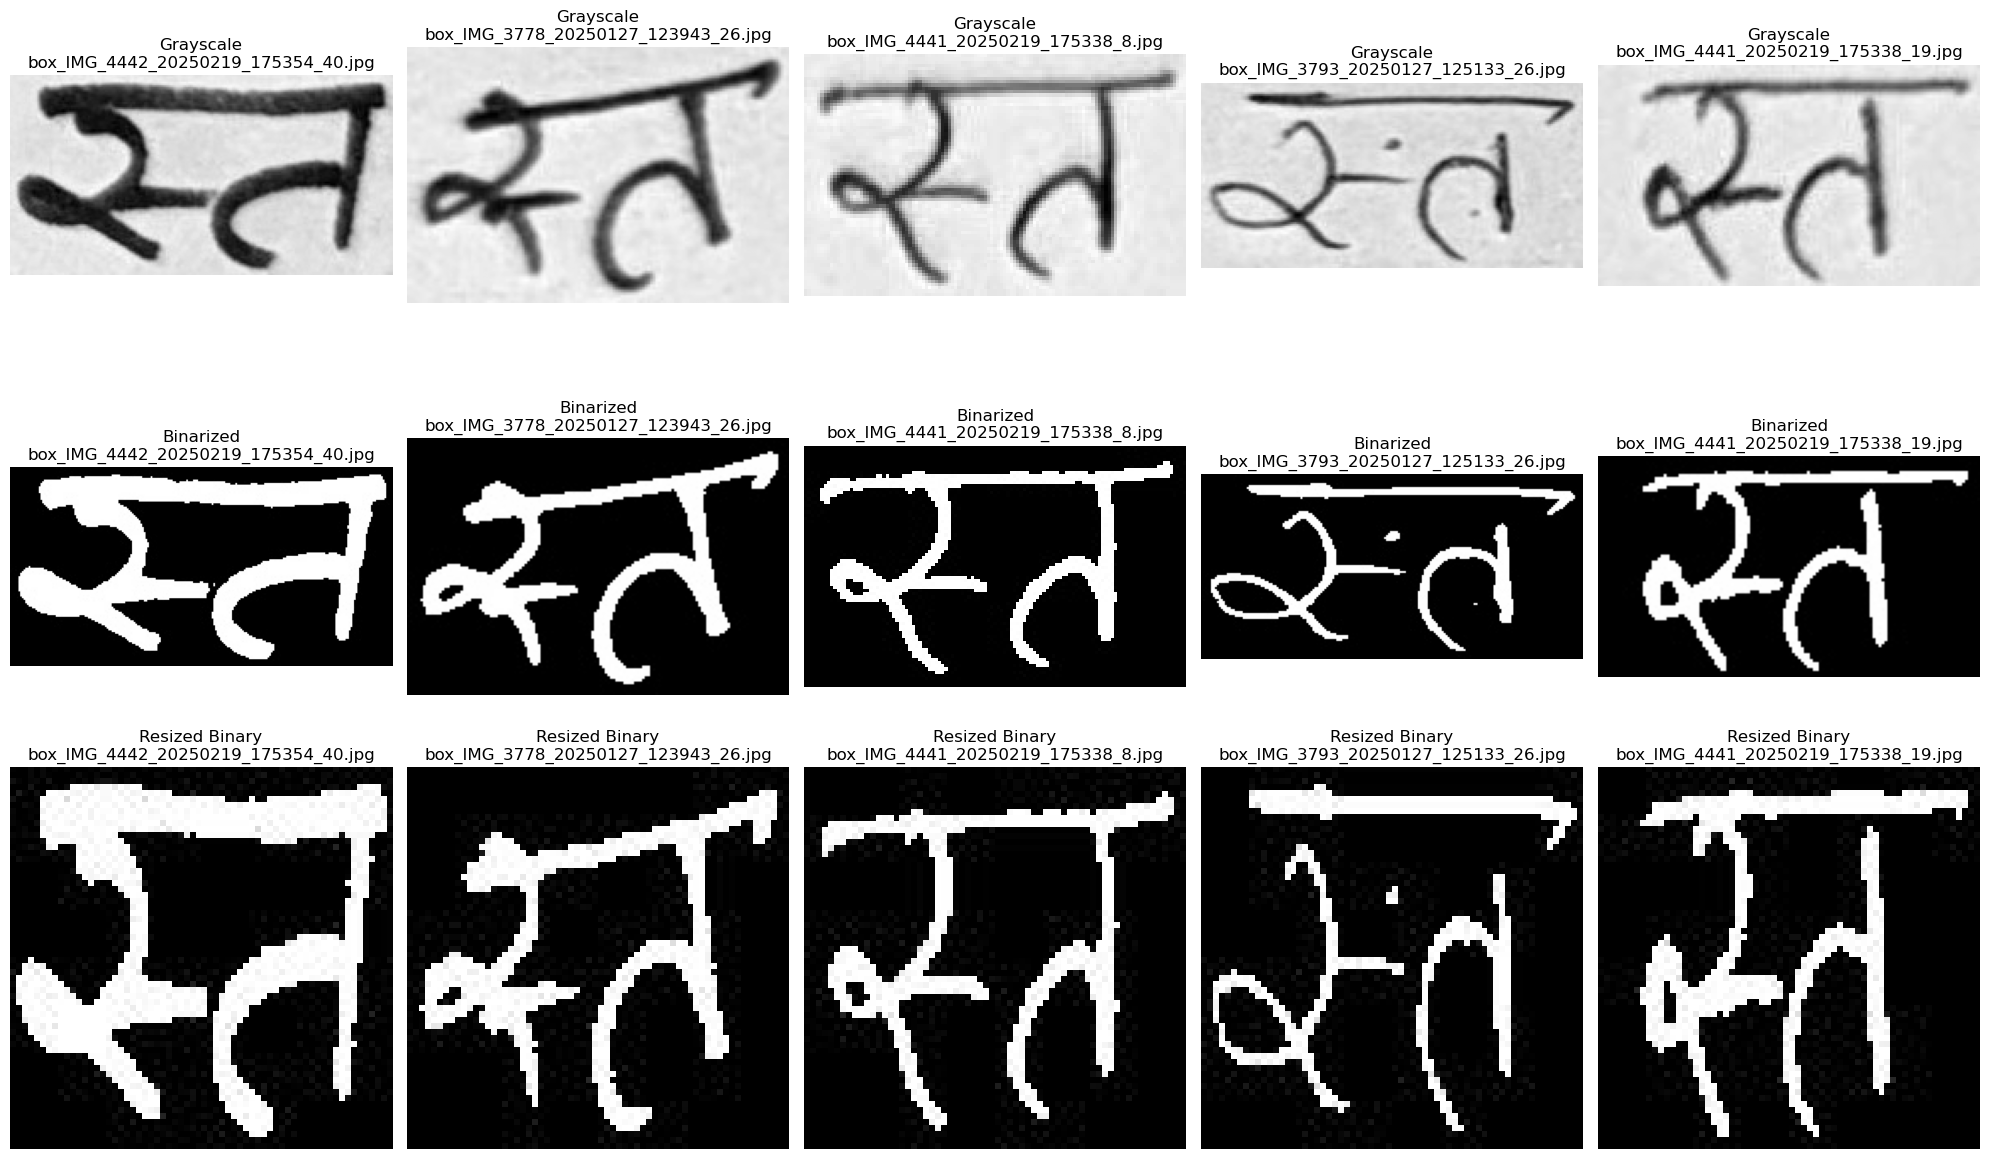

In [ ]:
# Get the list of filenames that appear in all folders (assuming they are the same)
files_gray = set(os.listdir(output_folder_gray))
files_binary = set(os.listdir(output_folder_binary))
files_resized = set(os.listdir(resized_output_folder))
common_files = list(files_gray & files_binary & files_resized)

# Randomly sample 5 filenames from the common set
num_samples = 5
if len(common_files) < num_samples:
    print("Not enough common files found!")
    sampled_files = common_files
else:
    sampled_files = random.sample(common_files, num_samples)

# Create a subplot grid with 3 rows (one for each image type) and as many columns as samples
fig, axes = plt.subplots(3, len(sampled_files), figsize=(4 * len(sampled_files), 12))

# Loop over each file and display images from each folder in the same column
for col, file in enumerate(sampled_files):
    # Read grayscale image (using cv2, which reads in B/W as a 2D array)
    gray = cv2.imread(os.path.join(output_folder_gray, file), cv2.IMREAD_GRAYSCALE)
    # Read binarized image
    binary = cv2.imread(os.path.join(output_folder_binary, file), cv2.IMREAD_GRAYSCALE)
    # Read resized binary image
    resized = cv2.imread(os.path.join(resized_output_folder, file), cv2.IMREAD_GRAYSCALE)

    # Display grayscale image in row 0
    axes[0, col].imshow(gray, cmap='gray')
    axes[0, col].set_title(f"Grayscale\n{file}")
    axes[0, col].axis('off')

    # Display binarized image in row 1
    axes[1, col].imshow(binary, cmap='gray')
    axes[1, col].set_title(f"Binarized\n{file}")
    axes[1, col].axis('off')

    # Display resized binary image in row 2
    axes[2, col].imshow(resized, cmap='gray')
    axes[2, col].set_title(f"Resized Binary\n{file}")
    axes[2, col].axis('off')

plt.tight_layout()
plt.show()